In [5]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [1]:
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Layer, Dense, Embedding
from tensorflow.keras.layers import LayerNormalization, MultiHeadAttention, Add, Flatten
from keras.models import Sequential
from tensorflow.keras import Model

In [7]:
image = cv2.imread("/content/drive/MyDrive/Potato Dataset/Potato___Late_blight/02282fee-ba3f-460e-91e0-630204ab96c2___RS_LB 5031.JPG")
image = cv2.resize(image, (256, 256))

In [9]:
hp = {
    'path' : "/content/drive/MyDrive/Potato Dataset",
    'batchSize' : 32,
    'imgSize' : 256,
    'learningRate' : 1e-3,
    'epochs' : 10,
    'dropout' : 0,
    'patchSize' : 16,
    'projDim' : 768,
    'numClasses' : 3
}

In [10]:
patches = tf.image.extract_patches(images=tf.expand_dims(image, axis = 0),
                           sizes=[1, 16, 16, 1],
                           strides=[1, 16, 16, 1],
                           rates=[1, 1, 1, 1],
                           padding='VALID')

In [11]:
patches.shape # 16 x 16 x 3 = 768

TensorShape([1, 16, 16, 768])

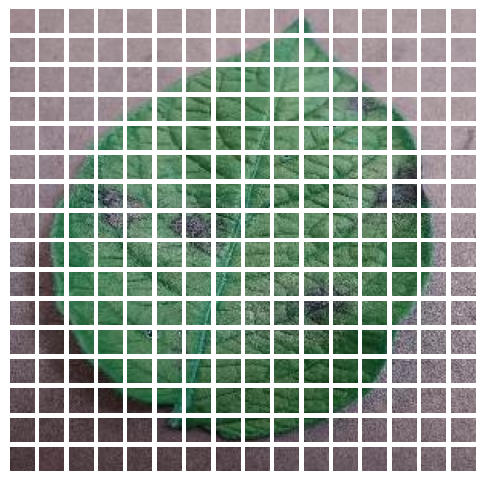

In [12]:
plt.figure(figsize = (6,6))
k = 0
for i in range(16):
    for j in range(16):
        ax = plt.subplot(16,16,k+1)
        plt.imshow(tf.reshape(patches[0,i,j,:],(16,16,3)))
        plt.axis('off')
        k+=1

In [13]:
patches = tf.reshape(patches, (patches.shape[0], 256, 768)) # (patches.shape[0], -1, 768)
patches.shape

TensorShape([1, 256, 768])

In [14]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    hp['path'],
    seed = 123,
    shuffle = True,
    image_size = (hp['imgSize'],hp['imgSize']),
    batch_size = hp['batchSize']
)
classNames = dataset.class_names
print(classNames)

Found 2162 files belonging to 3 classes.
['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


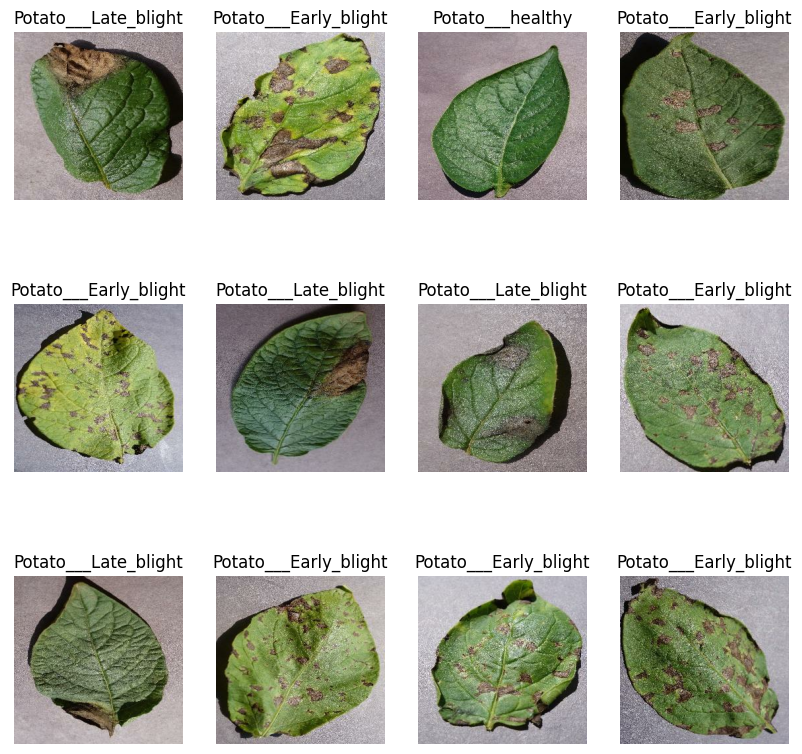

In [15]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(classNames[label_batch[i]])
        plt.axis("off")

In [16]:
def datasetPartition(dataset, trainSplit = 0.8, validSplit = 0.1, testSplit = 0.1, shuffle = True, shuffleSize = 10000):

    assert (trainSplit + testSplit + validSplit) == 1
    datasetSize = len(dataset)

    if shuffle:
        dataset = dataset.shuffle(shuffleSize, seed=12)

    trainSize = int(trainSplit * datasetSize)
    validSize = int(validSplit * datasetSize)

    train = dataset.take(trainSize)
    valid = dataset.skip(trainSize).take(validSize)
    test = dataset.skip(trainSize).skip(validSize)

    return train, valid, test

In [17]:
train, valid, test = datasetPartition(dataset)
print(len(train),len(valid),len(test))

54 6 8


In [54]:
class PatchEncoder(Layer):

    def __init__(self, numPatches, hiddenSize):
        super(PatchEncoder, self).__init__(name = 'Patch_Encoder')
        self.linearProjection = Dense(hiddenSize)
        self.positionalEmbedding = Embedding(numPatches, hiddenSize)
        self.numPatches = numPatches

    def call(self, x):
        patches = tf.image.extract_patches(
            images = x,
            sizes=[1, hp['patchSize'], hp['patchSize'], 1],
            strides=[1, hp['patchSize'], hp['patchSize'], 1],
            rates=[1, 1, 1, 1],
            padding='VALID')
        # patches = tf.reshape(patches, (patches.shape[0], -1, patches.shape[-1]))
        # patches = tf.reshape(patches, (hp['batchSize'], -1, patches.shape[-1]))
        patches = tf.reshape(patches, (tf.shape(patches)[0], 256, patches.shape[-1]))
        embeddingInput = tf.range(start = 0, limit = self.numPatches, delta = 1)
        output = self.linearProjection(patches) + self.positionalEmbedding(embeddingInput)

        return output

In [55]:
# patchEncoder = PatchEncoder(256, 768)
# # patchEncoder(tf.zeros([1, 256, 256, 3]))
# patchEncoder(tf.zeros([32, 256, 256, 3]))

In [56]:
class TransformerEncoder(Layer):

    def __init__(self, numHeads, hiddenSize):
        super(TransformerEncoder, self).__init__(name = 'Transformer_Encoder')
        self.layerNorm_1 = LayerNormalization()
        self.layerNorm_2 = LayerNormalization()
        self.multiHeadAttention = MultiHeadAttention(numHeads, hiddenSize)
        self.dense_1 = Dense(hiddenSize, activation = tf.nn.gelu)
        self.dense_2 = Dense(hiddenSize, activation = tf.nn.gelu)

    def call(self, input):
        x1 = self.layerNorm_1(input)
        x1 = self.multiHeadAttention(x1, x1)
        x1 = Add()([x1, input])
        x2 = self.layerNorm_2(x1)
        x2 = self.dense_1(x2)
        out = self.dense_2(x2)
        out = Add()([out, x1])

        return out

In [57]:
# transformerEncoder = TransformerEncoder(8, 768) # no. of heads = 8
# # transformerEncoder(tf.zeros([1, 256, 768]))
# transformerEncoder(tf.zeros([32, 256, 768]))

In [58]:
class ViT(Model):

    def __init__(self, numHeads, hiddenSize, numPatches, numLayers, numDenseUnits):
        super(ViT, self).__init__(name = 'Vision_Transformer')
        self.numLayers = numLayers
        self.patchEncoder = PatchEncoder(numPatches,hiddenSize)
        self.transEncoders = [TransformerEncoder(numHeads, hiddenSize) for _ in range(numLayers)]
        self.dense_1 = Dense(numDenseUnits, tf.nn.gelu)
        self.dense_2 = Dense(numDenseUnits, tf.nn.gelu)
        self.dense_3 = Dense(hp['numClasses'], activation = 'softmax')

    def call(self, input, training = True):
        x = self.patchEncoder(input)
        for i in range(self.numLayers):
            x = self.transEncoders[i](x)
        x = Flatten()(x)
        x = self.dense_1(x)
        x = self.dense_2(x)

        return self.dense_3(x)

In [59]:
vit = ViT(numHeads = 4, hiddenSize = 768, numPatches = 256, numLayers = 2, numDenseUnits = 128)
vit(tf.zeros([2, 256, 256, 3]))

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.32694596, 0.27218303, 0.40087095],
       [0.32694596, 0.27218303, 0.40087095]], dtype=float32)>

In [60]:
vit.summary()

Model: "Vision_Transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Patch_Encoder (PatchEncode  multiple                  787200    
 r)                                                              
                                                                 
 Transformer_Encoder (Trans  multiple                  10631424  
 formerEncoder)                                                  
                                                                 
 Transformer_Encoder (Trans  multiple                  10631424  
 formerEncoder)                                                  
                                                                 
 dense_101 (Dense)           multiple                  25165952  
                                                                 
 dense_102 (Dense)           multiple                  16512     
                                                

In [61]:
vit.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[
        tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
        tf.keras.metrics.SparseTopKCategoricalAccuracy(10, name="top-10-accuracy"),
    ],
)

In [62]:
history = vit.fit(
    train,
    epochs = hp['epochs'],
    validation_data = valid,
    verbose = 1,
)

Epoch 1/10
54/54 [==============================] - 225s 549ms/step - loss: 9908.8662 - accuracy: 0.4761 - top-10-accuracy: 1.0000 - val_loss: 2240.6082 - val_accuracy: 0.6719 - val_top-10-accuracy: 1.0000
Epoch 2/10
54/54 [==============================] - 35s 527ms/step - loss: 1115.5148 - accuracy: 0.7396 - top-10-accuracy: 1.0000 - val_loss: 129.9213 - val_accuracy: 0.8750 - val_top-10-accuracy: 1.0000
Epoch 3/10
54/54 [==============================] - 33s 505ms/step - loss: 171.0590 - accuracy: 0.8448 - top-10-accuracy: 1.0000 - val_loss: 118.5536 - val_accuracy: 0.8958 - val_top-10-accuracy: 1.0000
Epoch 4/10
54/54 [==============================] - 38s 564ms/step - loss: 38.5551 - accuracy: 0.9049 - top-10-accuracy: 1.0000 - val_loss: 18.6898 - val_accuracy: 0.9583 - val_top-10-accuracy: 1.0000
Epoch 5/10
54/54 [==============================] - 36s 559ms/step - loss: 18.6980 - accuracy: 0.9492 - top-10-accuracy: 1.0000 - val_loss: 0.2970 - val_accuracy: 0.9948 - val_top-10-acc

In [64]:
print('Training results')
vit.evaluate(train)

print('Validation results')
vit.evaluate(valid)

Training results
54/54 [==============================] - 18s 149ms/step - loss: 1.3660 - accuracy: 0.9918 - top-10-accuracy: 1.0000
Validation results
6/6 [==============================] - 13s 155ms/step - loss: 0.6163 - accuracy: 0.9948 - top-10-accuracy: 1.0000


[0.6162709593772888, 0.9947916865348816, 1.0]

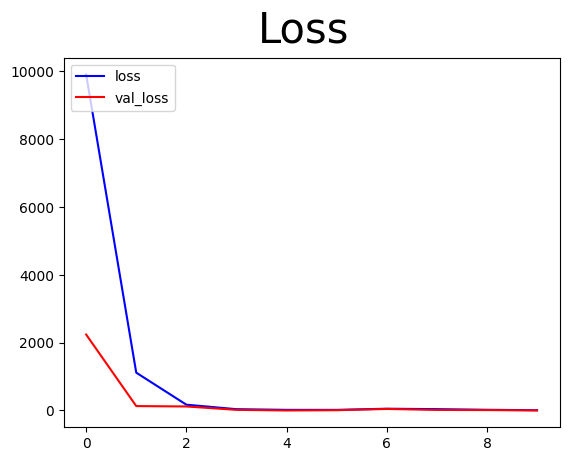

In [65]:
fig = plt.figure()
plt.plot(history.history['loss'],color='blue',label='loss')
plt.plot(history.history['val_loss'],color='red',label='val_loss')
plt.suptitle('Loss',fontsize=30)
plt.legend(loc='upper left')
plt.show()

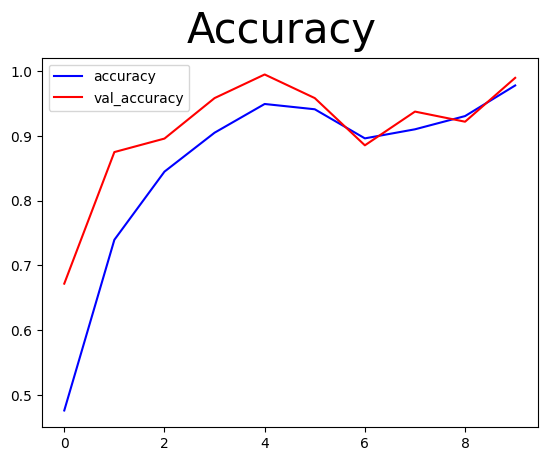

In [66]:
fig = plt.figure()
plt.plot(history.history['accuracy'],color='blue',label='accuracy')
plt.plot(history.history['val_accuracy'],color='red',label='val_accuracy')
plt.suptitle('Accuracy',fontsize=30)
plt.legend(loc='upper left')
plt.show()

In [67]:
from tensorflow.keras.metrics import Precision, Recall
import numpy as np

pre = Precision()
re = Recall()

for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = vit.predict(X)
    yhat = np.argmax(yhat, axis=1)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)

1/1 [==============================] - 0s 71ms/step


In [68]:
print("Precision: ",pre.result().numpy(),"Recall: ",re.result().numpy())

Precision:  0.98507464 Recall:  1.0


In [69]:
vit.save('/content/drive/MyDrive/Colab Notebooks/vit_potato_disease_detection')